<a href="https://colab.research.google.com/github/ehadsaloF/Multinomial-Logistic-Regression/blob/main/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Analysis of Customer Data Using Multiple Logistic Regression 

The main objective of this report is to analyse customer data from Fresco Supermarket and identify trends and patterns. The data used for this analysis was collected for several of their loyalty cardholders during a 26-week period. The data includes information on the customers’ gender, age, shopping frequency per week and shopping basket price. 

In [ ]:
#import neccessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import metrics 
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# setting logging to print only error messages from Sklearnex
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

import warnings
warnings.filterwarnings('ignore')

#setting style
sns.set_style('white')

### Loading the Data

In [ ]:
df = pd.read_excel('Portfolio-Task-1-Data_Fresco.xlsx')

In [ ]:
#viewing the first five records in the datastet
df.head()

,CustomerID,Shopping Basket,Gender,Age,Store Type,Value Products,Brand Products,Top Fresco Products
0,62507227,91.37,Male,41,Online,31,15,15
1,33786344,64.26,Female,37,Superstore,13,4,4
2,46393752,76.60,Female,64,Superstore,31,17,17
3,48985995,59.15,Female,48,Superstore,23,11,4
4,35940563,11.62,Male,19,Superstore,5,4,1


In [ ]:
df.shape

(750, 8)

The data set has 9 columns and 750 rows.


In [ ]:
#creating a variable containing three categories based on 
#shopping basket values
#Low spender for values of £25 or less, 
#medium spender for values between £25.01 and £70 and 
#high spender for values greater than £70.  

bins = [0, 25.01, 70, np.inf]
names = ['low_spender', 'med_spender', 'high_spender']

df['SpendingRange'] = pd.cut(df['Shopping Basket'], bins, labels=names)

The shopping basket price was categorized into three categories: Low spender for values of £25 or less, medium spender for values between £25.01 and £70 and high spender for values greater than £70.  

### Data Splitting

The data is split into training and testing datasets. The training dataset is used to train the model and the testing data set is used to evaluate the performance on the model on real world data.

Stratified sampling is used in this project.

In [ ]:
# splitting the data into two parts, training set with 70% of the data
# and testing set with 30% of the data
trainset, testset = train_test_split(df, test_size = 0.3, random_state = 9,
                 stratify = df["SpendingRange"])

### Exploratory Data Analysis

In [ ]:
#checking the columns and their datatypes
trainset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 525 entries, 510 to 328
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   CustomerID           525 non-null    int64   
 1   Shopping Basket      525 non-null    float64 
 2   Gender               525 non-null    object  
 3   Age                  525 non-null    int64   
 4   Store Type           525 non-null    object  
 5   Value Products       525 non-null    int64   
 6   Brand Products       525 non-null    int64   
 7   Top Fresco Products  525 non-null    int64   
 8   SpendingRange        525 non-null    category
dtypes: category(1), float64(1), int64(5), object(2)
memory usage: 37.6+ KB


From the table above, there are 3 categorical variables, the gender, storetype and spending range. it is observed that there are no null values in the dataset.

In [ ]:
#checking the shape of the trainset
trainset.shape

(525, 9)

The training data set has 9 columns and 525 rows.

#### Descriptive Statistics

In [ ]:
#displaying the proportions of categories for each categorical variable
trainset['Gender'].value_counts(normalize=True)

Male      0.504762
Female    0.483810
male      0.011429
Name: Gender, dtype: float64

In [ ]:
#from the output above, the male gender is listed twice because of
#python's case sensitivity

#replacing the 'male' category with 'Male' category for the trainset
# and testset
trainset['Gender'] = trainset['Gender'].replace({
    'male':'Male'
})

testset['Gender'] = testset['Gender'].replace({
    'male':'Male'
})

In [ ]:
trainset['Gender'].value_counts(normalize=True)

Male      0.51619
Female    0.48381
Name: Gender, dtype: float64

From the output, we see there are two unique catgories in the gender variable with almost similar proportions.

In [ ]:
trainset['Store Type'].value_counts(normalize=True)

Superstore           0.464762
Online               0.276190
Convenient Stores    0.259048
Name: Store Type, dtype: float64

From the output, we see there are three unique Store Type with Superstores having the highest proportion.

In [ ]:
trainset['SpendingRange'].value_counts(normalize=True)

med_spender     0.398095
high_spender    0.369524
low_spender     0.232381
Name: SpendingRange, dtype: float64

From the output, we see there are three unique catgories of spenders with medium spenders having the highest proportion, followed by high spenders.

In [ ]:
#dropping the customerID and ShoppingBasket variables as they won't be
# important in our analysis
trainset = trainset.drop(['CustomerID', 'Shopping Basket'], axis = 1)

testset = testset.drop(['CustomerID', 'Shopping Basket'], axis = 1)

In [ ]:
trainset.head()

,Gender,Age,Store Type,Value Products,Brand Products,Top Fresco Products,SpendingRange
510,Female,22,Convenient Stores,2,4,10,med_spender
502,Male,68,Online,18,9,12,med_spender
652,Female,36,Superstore,7,9,8,med_spender
204,Female,52,Superstore,30,18,14,high_spender
43,Female,23,Convenient Stores,9,4,2,low_spender


In [ ]:
trainset.describe()

,Age,Value Products,Brand Products,Top Fresco Products
count,525.000000,525.000000,525.000000,525.000000
mean,38.733333,15.847619,8.651429,6.977143
std,13.449557,12.327730,6.109561,5.230877
min,19.000000,0.000000,0.000000,-1.000000
25%,26.000000,6.000000,4.000000,3.000000
50%,38.000000,13.000000,8.000000,6.000000
75%,48.000000,22.000000,13.000000,10.000000
max,68.000000,52.000000,23.000000,22.000000


#### Data Visualization

<AxesSubplot:xlabel='Gender', ylabel='count'>

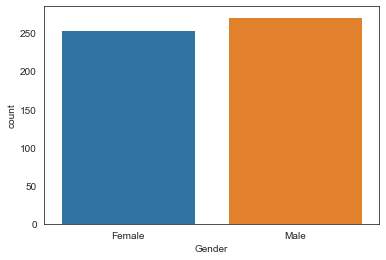

In [ ]:
#The barchart of the gender variable
sns.countplot(trainset["Gender"], 
              order=trainset["Gender"].value_counts(ascending=True).index)


<AxesSubplot:xlabel='Store Type', ylabel='count'>

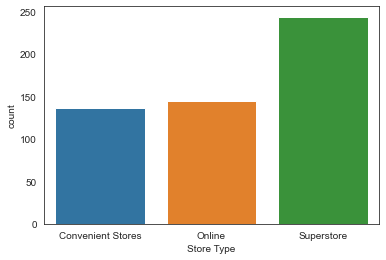

In [ ]:
#The barchart of the store type variable
sns.countplot(trainset["Store Type"], 
              order=trainset["Store Type"].value_counts(ascending=True).index)

<AxesSubplot:xlabel='SpendingRange', ylabel='count'>

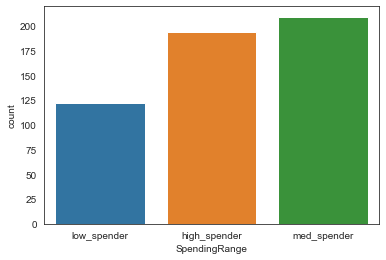

In [ ]:
#The barchart of the spending range variable
sns.countplot(trainset["SpendingRange"], 
              order=trainset["SpendingRange"].value_counts(ascending=True).index)

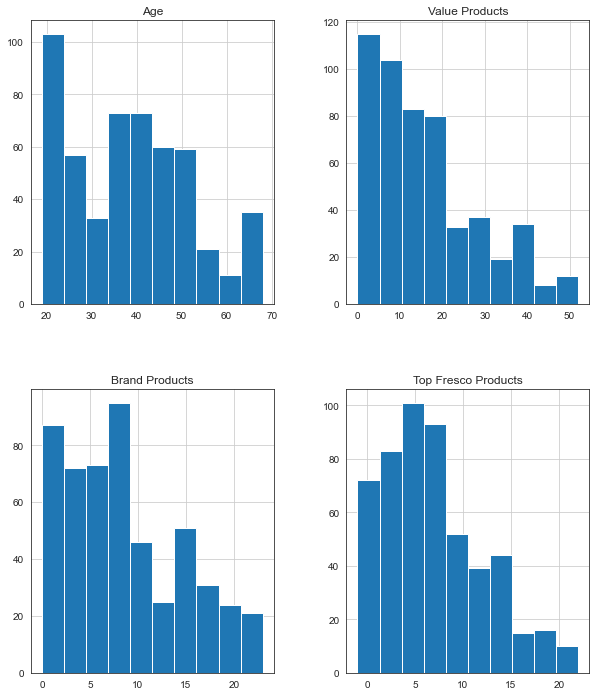

In [ ]:
#The histogram of all continuous variables in the trainset.
histograms = trainset.hist(bins=10, figsize=(10,12))


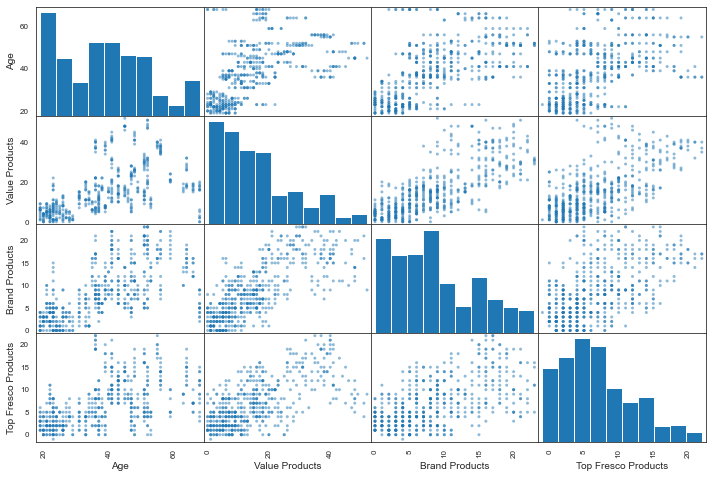

In [ ]:
#scatter plots showing the relationship between the continous variables
scatter_plots = scatter_matrix(trainset, figsize=(12, 8))

### Model Building


In [ ]:
#recoding the categories for each categorical variable to numbers

#for the train set

#for Gender
# 1 represent Female
# 0 represent Male
trainset['Gender'] = trainset['Gender'].replace({
    'Male': 0,
    'Female': 1
})

#for Store Type
# 0 represent Convenient Stores 
# 1 represent Online
# 2 represent Superstore
trainset['Store Type'] = trainset['Store Type'].replace({
    'Convenient Stores': 0,
    'Online': 1,
    'Superstore': 2 
})


#for SpendingRange
# 0 represent low_spender
# 1 represent med_spender
# 2 represent high_spender
trainset['SpendingRange'] = trainset['SpendingRange'].replace({
    'low_spender': 0,
    'med_spender': 1,
    'high_spender': 2 
})



In [ ]:
#for the test set

#for Gender
testset['Gender'] = testset['Gender'].replace({
    'Male': 0,
    'Female': 1
})

#for Store Type
testset['Store Type'] = testset['Store Type'].replace({
    'Convenient Stores': 0,
    'Online': 1,
    'Superstore': 2 
})


#for SpendingRange
testset['SpendingRange'] = testset['SpendingRange'].replace({
    'low_spender': 0,
    'med_spender': 1,
    'high_spender': 2 
})

In [ ]:
#dividing the test and train sets into the target variable(y) and
# the independent variables (X)

X_train = trainset.drop('SpendingRange', axis = 1)
y_train = trainset['SpendingRange']


X_test = testset.drop('SpendingRange', axis = 1)
y_test = testset['SpendingRange']

In [ ]:
X_train.head()

,Gender,Age,Store Type,Value Products,Brand Products,Top Fresco Products
510,1,22,0,2,4,10
502,0,68,1,18,9,12
652,1,36,2,7,9,8
204,1,52,2,30,18,14
43,1,23,0,9,4,2


In [ ]:
y_train.head()

510    1
502    1
652    1
204    2
43     0
Name: SpendingRange, dtype: int64

#### Base Model


In [ ]:
#for this project, the base model's prediction will be the mode of the SpendingRange

yhat_base = np.full((y_train.shape[0], 1), y_train.mode())


#viewing the accuracy and the macro averaged precision, recall and F1 score of the base model
print('Base Model\'s Accuracy is: ', accuracy_score(y_train, yhat_base))
print('Base Model\'s Precision is: ', precision_score(y_train, yhat_base, average = 'macro'))
print('Base Model\'s Recall is: ', recall_score(y_train, yhat_base, average = 'macro'))
print('Base Model\'s F1 Score is: ', f1_score(y_train, yhat_base, average = 'macro'))

Base Model's Accuracy is:  0.3980952380952381
Base Model's Precision is:  0.1326984126984127
Base Model's Recall is:  0.3333333333333333
Base Model's F1 Score is:  0.18982742960944599


#### Checking For Linearity

Before estimating the model, we check for linearity by running a logistic regression including all interactions between the independent continuous variables and their natural log values.

In [ ]:

#Interactions
X_train['Age*lnAge'] = np.log(X_train['Age']) * X_train['Age']
X_train['ValueProducts*lnValueProducts'] = np.log(X_train['Value Products']) * X_train['Value Products']
X_train['BrandProducts*lnBrandProducts'] = np.log(X_train['Brand Products']) * X_train['Brand Products']
X_train['TopFrescoProducts*lnTopFrescoProducts'] = np.log(X_train['Top Fresco Products']) * X_train['Top Fresco Products']

X_train['Age*lnAge'] = X_train['Age*lnAge'].replace({
    np.nan : 0
})
X_train['ValueProducts*lnValueProducts'] = X_train['ValueProducts*lnValueProducts'].replace({
    np.nan : 0
})
X_train['BrandProducts*lnBrandProducts'] = X_train['BrandProducts*lnBrandProducts'].replace({
    np.nan : 0
})
X_train['TopFrescoProducts*lnTopFrescoProducts'] = X_train['TopFrescoProducts*lnTopFrescoProducts'].replace({
    np.nan : 0
})



In [ ]:
#interaction variables
interaction_vars = ['Age', 'Value Products', 'Brand Products', 'Top Fresco Products',
                    'Age*lnAge', 'ValueProducts*lnValueProducts', 
                    'BrandProducts*lnBrandProducts', 
                    'TopFrescoProducts*lnTopFrescoProducts']

X_ln = X_train[interaction_vars]

#using the statsmodel Logistic regression so i can check the p-values of interaction terms
linearity_model = sm.MNLogit(y_train,sm.add_constant(X_ln))


In [ ]:
result = linearity_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.319525
         Iterations 11
                          MNLogit Regression Results                          
Dep. Variable:          SpendingRange   No. Observations:                  525
Model:                        MNLogit   Df Residuals:                      507
Method:                           MLE   Df Model:                           16
Date:                Sun, 17 Jul 2022   Pseudo R-squ.:                  0.7024
Time:                        11:24:30   Log-Likelihood:                -167.75
converged:                       True   LL-Null:                       -563.68
Covariance Type:            nonrobust   LLR p-value:                3.452e-158
                      SpendingRange=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                   -29.1031     

For the assumption of linearity to hold, none of the interactions should have a significant coefficient.

From the table above, the significance of the coefficients of the interactions of all continous variables except 'Age' are greater than 0.05 in at least one of the logistic models. 

This implies that for the linearity assumption to hold, the age variable has to be removed. 

#### Model Estimation

The Multinomial Logistic Regression model is estimated using statsmodel Logistic regression with the reference category being spending range with value of 0, low spenders.

In [ ]:
#droppping the age variables and the interactions
X_train = X_train.drop(['Age', 'Age*lnAge', 'ValueProducts*lnValueProducts', 
              'BrandProducts*lnBrandProducts', 
              'TopFrescoProducts*lnTopFrescoProducts'], axis = 1)

#using the statsmodel Logistic regression 
main_model = sm.MNLogit(y_train,sm.add_constant(X_train))

result = main_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.408808
         Iterations 10
                          MNLogit Regression Results                          
Dep. Variable:          SpendingRange   No. Observations:                  525
Model:                        MNLogit   Df Residuals:                      513
Method:                           MLE   Df Model:                           10
Date:                Sun, 17 Jul 2022   Pseudo R-squ.:                  0.6192
Time:                        11:26:59   Log-Likelihood:                -214.62
converged:                       True   LL-Null:                       -563.68
Covariance Type:            nonrobust   LLR p-value:                1.595e-143
    SpendingRange=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -6.0514      0.758     -7.984      0.000      -7.537      -4.566
G

Variables with significance greater than 0.05 are removed as they are statistically insignificant in the model. 

Only the store type is insignificant in our model.


The parsimonious model is obtained by removing the most insignificant variables and re-estimating the model until all variables are significant in at least one logisitic model. 

In [ ]:
#droppping the store type variables
#X_train = X_train.drop(['Store Type'], axis = 1)

#using the statsmodel Logistic regression 
main_model = sm.MNLogit(y_train,sm.add_constant(X_train))

result = main_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.409447
         Iterations 10
                          MNLogit Regression Results                          
Dep. Variable:          SpendingRange   No. Observations:                  525
Model:                        MNLogit   Df Residuals:                      515
Method:                           MLE   Df Model:                            8
Date:                Sun, 17 Jul 2022   Pseudo R-squ.:                  0.6187
Time:                        11:45:53   Log-Likelihood:                -214.96
converged:                       True   LL-Null:                       -563.68
Covariance Type:            nonrobust   LLR p-value:                2.542e-145
    SpendingRange=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -6.0708      0.757     -8.016      0.000      -7.555      -4.586
G

From the table above, all variables are significant in at least one of the logistic models. This is our parsimonious model. 

### Checking for Assumptions
Before estimating the model, we checked for linearity. The assumption of linearity holds. 
For independence of errors, we also checked if the ratio between the chi-squared value for the goodness of fit test and its degrees of freedom is lower than 2.  

In [ ]:
observed = result.predict(X_test, exog=None, linear=False)
stats.chi2_contingency(observed= observed)

TypeError: predict() got multiple values for argument 'exog'

In [ ]:
pd.DataFrame({'variables':X_train.columns[1:], 
              'VIF':[variance_inflation_factor(X_train.values, 
                                               i+1) for i in range(len(X_train.columns[1:]))]})






,variables,VIF
0,Value Products,7.258483
1,Brand Products,7.015261
2,Top Fresco Products,4.625377
